In [1]:
import pickle
import pandas as pd
from CITEsort_rna.BTreeTraversal import BTreeTraversal
from CITEsort_rna.Visualize import plot_keymarker,visualize_tree
import matplotlib
#import numpy as np
from matplotlib import pyplot as plt
import scanpy as sc
from metadimm import MetaDIMM

## load data and tree 

In [9]:
id='1_5'
adata = sc.read_h5ad('../simulator_out/RNA_simulator_'+id+'.h5ad')
# ct_list = ['CD4 Naive','CD8 Naive','CD14 Mono']
# adata = adata[adata.obs['label_l2'].isin(ct_list),:]
# adata = sc.read_h5ad('./output/rna/CD4_CD8_Naive_CD14_Mono/adata_pp.h5ad')
f = open('../output/'+id+'_rna/tree.pickle','rb')
# f = open('CITEsort_out/SeuratV3_main_ct_smooth2/tree.pickle','rb')
tree = pickle.load(f)
f.close()



In [10]:
traversal = BTreeTraversal(tree)
md = MetaDIMM()
adata = adata[tree.indices,:]
# adata = md.filter(adata)
adata = md.preprocess(adata, normalize=True, log1p=True, hvg=True, scale=True)

label = pd.read_csv('../simulator_out/droplets_composition_'+id+'.csv')
label.index = label.index.astype(str)
adata.obs['label'] = label['cell_type']

/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


----------------------------------------
Function 'preprocess' executed in 12.66s
----------------------------------------


## plot compact tree or complete tree
#### The paramter '--compact' of runing runCITEsort.py will set the tree in compact format. If complete format is needed, plot tree again as below. The filename should no longer be 'tree', or the original tree.pdf will be overwritten.

In [4]:
# visualize_tree(tree,data,outpath='./CITEsort_out',filename='tree_complete',compact=False)

## visualize all markers in a certain node
#### the node ID is just the number before the node name in tree.pdf

/home/xinzhu/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/xinzhu/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


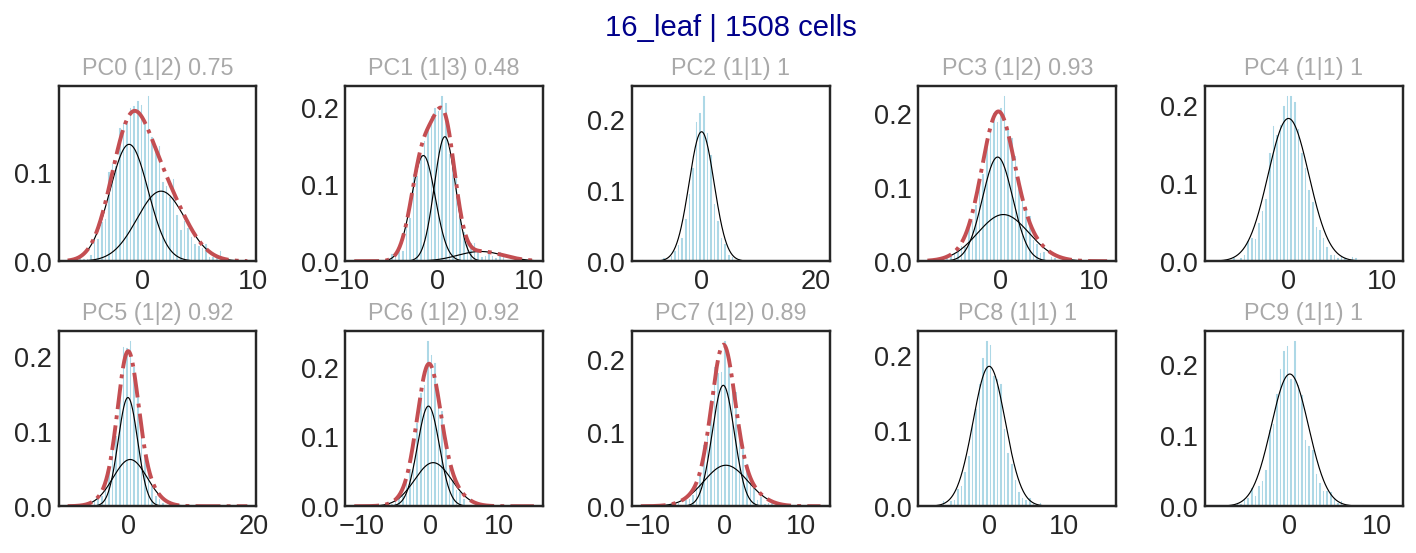

In [160]:
node_ID = 16
traversal.plot_node(adata,node_ID,viz_dim=1,savefig=False)

In [186]:
node = traversal.get_node(3)
node.all_clustering_dic[1][('PC1',)]['max_val']
# node.stop

0.7

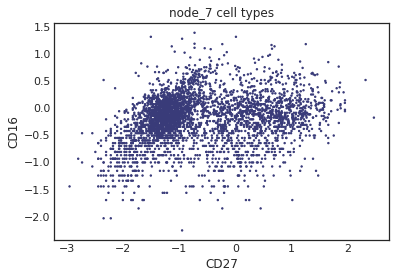

In [ ]:
traversal.plot_node_2dim_new(adata, 7, 'CD27', 'CD16')
# traversal.plot_node_2dim_new(data, 20, 'CD8a', 'CD4')
# traversal.plot_node_2dim_new(data, 2, 'CD4-1', 'CD19')

## learn markers of each cell type

In [11]:
pred_rna = pd.read_csv('../output/'+id+'_rna/leaf_labels.csv',index_col=0)
pred_rna.index  = pred_rna.index.astype(str)
adata.obs['pred_rna'] = pred_rna['Label']
sc.tl.rank_genes_groups(adata, groupby='pred_rna', method='t-test')


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [5]:
idnew = '2_1'
adata_new = sc.read_h5ad('../simulator_out/RNA_simulator_'+idnew+'.h5ad')
# adata_new = md.preprocess(adata, normalize=True, log1p=True, hvg=False, scale=True)

In [6]:
adata_npp = md.preprocess(adata, normalize=True, log1p=True, hvg=False, scale=True)

/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(X, out=X)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


---------------------------------------
Function 'preprocess' executed in 8.70s
---------------------------------------


In [259]:
from sklearn.mixture import GaussianMixture
DE_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][:2000])
label_gmm = pd.DataFrame(index=adata_new.obs_names)
for ct in DE_genes.columns:
    # ct='11_leaf'
    genelist = DE_genes.loc[:,ct].values
    adata_sub = adata_new[:,genelist]
    # adata_sub = md.filter(adata_sub)
    # sc.pp.filter_cells(adata_sub, min_genes=100)
    adata_sub =  md.preprocess(adata_sub, normalize=True, log1p=True, hvg=False, scale=True)
    sc.tl.pca(adata_sub,n_comps=20)
    gm = GaussianMixture(n_components=2).fit(adata_sub.obsm['X_pca'])
    pred = gm.predict(adata_sub.obsm['X_pca'])
    # adata_sub.obs['gmm'] = pd.Series(index=adata_sub.obs_names, data=pred.astype(str))
    # sc.pp.neighbors(adata_sub)
    # sc.tl.umap(adata_sub)
    # sc.pl.umap(adata_sub,color='gmm')
    # sc.pl.pca(adata_sub,color='gmm',components=['1,2','3,4'])
    
    label_gmm[ct] = gm.predict_proba(adata_sub.obsm['X_pca'])[:,1-round(sum(pred)/len(adata_sub))]
    # break

/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.08s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.31s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.11s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.21s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.35s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.11s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.11s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.21s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.16s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.09s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.11s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.08s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 1.00s
---------------------------------------


/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


---------------------------------------
Function 'preprocess' executed in 0.95s
---------------------------------------


In [16]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

queue = [] 
newdict = dict()
dedict = dict()
queue.append(tree) 
newdict[0] = adata_npp.obs_names
ind = 0
pred_new = pd.Series(index=adata_new.obs_names,dtype='object')

while(len(queue) > 0): 
    node = queue.pop(0) 
    if node.left is not None:
        queue.append(node.left)
        queue.append(node.right) 

        adata_sub = adata[node.indices,:]
        adata_sub.obs['node_split'] = pd.Series(dtype='object')
        adata_sub.obs['node_split'].loc[node.left.indices] = str(0)
        adata_sub.obs['node_split'].loc[node.right.indices] = str(1)
        sc.tl.rank_genes_groups(adata_sub, groupby='node_split', method='t-test')
        DE_genes = pd.DataFrame(adata_sub.uns['rank_genes_groups']['names'][:1000])
        genes = list(set(list(DE_genes.loc[:,'0'])+list(DE_genes.loc[:,'1'])))

        clf = LinearDiscriminantAnalysis()
        clf.fit(adata_sub[:,genes].X, adata_sub.obs['node_split'])
        # clf.predict()

        # adata_sub = adata_npp[newdict[ind],genes]
        # pred = pd.Series(clf.predict(adata_sub),index=adata_sub.obs_names)
        # maxind = max(newdict.keys())
        # newdict[maxind+1] = adata_sub[pred=='0'].obs_names
        # newdict[maxind+2] = adata_sub[pred=='1'].obs_names
        # dedict[maxind+1] = DE_genes.loc[:,'0'].values
        # dedict[maxind+2] = DE_genes.loc[:,'1'].values

        # adata_sub = adata_new[newdict[ind],list(set(list(DE_genes.loc[:,'0'])+list(DE_genes.loc[:,'1'])))]
        # adata_sub =  md.preprocess(adata_sub, normalize=True, log1p=True, hvg=False, scale=True)
        # sc.tl.pca(adata_sub,n_comps=20)
        # gm = GaussianMixture(n_components=2).fit(adata_sub.obsm['X_pca'])
        # pred = pd.Series(gm.predict(adata_sub.obsm['X_pca']),index=adata_sub.obs_names)
        # tmp = [sum(sum(adata_sub[pred==0,DE_genes.loc[:,'0']].X))/sum(pred==0),sum(sum(adata_sub[pred==1,DE_genes.loc[:,'0']].X))/sum(pred==1)]
        # maxind = max(newdict.keys())
        # newdict[maxind+1] = adata_sub[pred==np.argmax(tmp),:].obs_names
        # newdict[maxind+2] = adata_sub[pred==(1-np.argmax(tmp)),:].obs_names
        # dedict[maxind+1] = DE_genes.loc[:,str(np.argmax(tmp))].values
        # dedict[maxind+2] = DE_genes.loc[:,str(1-np.argmax(tmp))].values
    else:
        pred_new.loc[newdict[ind]] = str(ind)+ '_leaf'
    ind = ind+1
    break


/tmp/ipykernel_2234697/2312207924.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sub.obs['node_split'] = pd.Series(dtype='object')


: 

: 

In [34]:
pred_new = pd.Series(index=adata_new.obs_names,dtype='object')

In [265]:
import numpy as np 
pred_final = label_gmm.idxmax(axis=1)

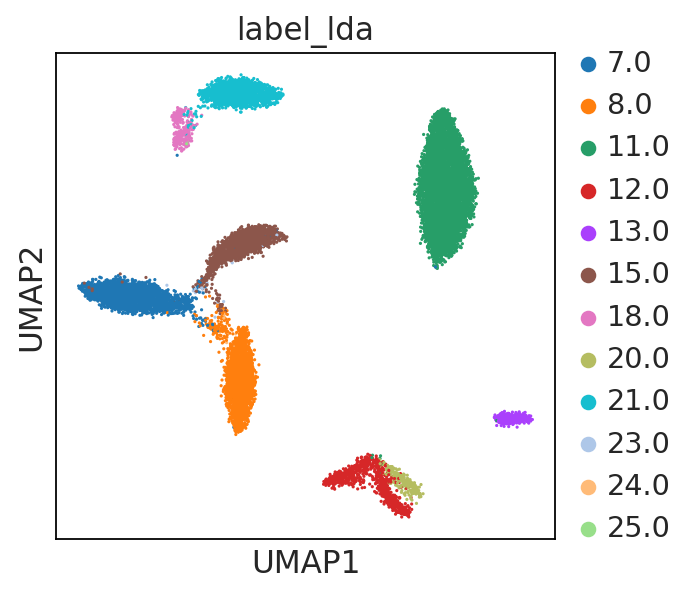

In [39]:
# adata_npp = md.preprocess(adata_new, normalize=True, log1p=True, hvg=False, scale=True)
# sc.tl.pca(adata_npp,n_comps=50)
# sc.pp.neighbors(adata_npp)
# sc.tl.umap(adata_npp)
adata_npp.obs['label_lda'] = pred_lda_.astype(str)
sc.pl.umap(adata_npp,color='label_lda')
# sc.pl.pca(adata_npp,color='label_final',components=['1,2','3,4'])

/tmp/ipykernel_2201576/4217436930.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  label_latent = pd.Series(index=adata_new.obs_names)


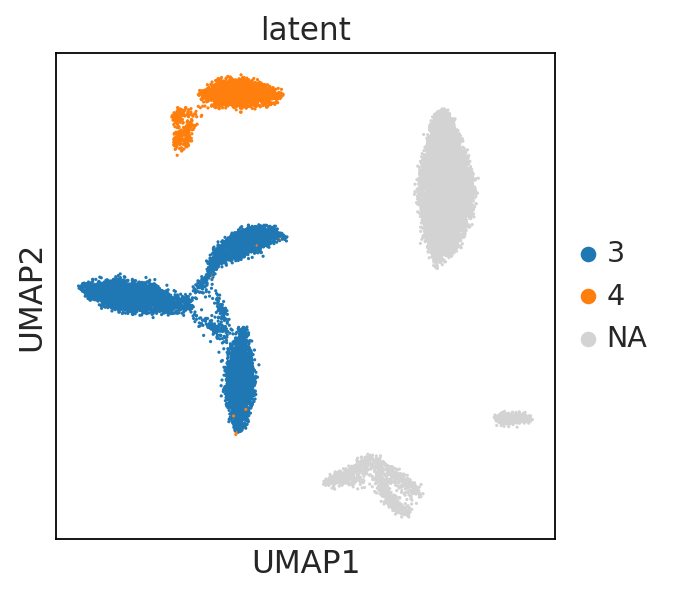

In [44]:
label_latent = pd.Series(index=adata_new.obs_names)
label_latent.loc[newdict[3]] = '3'
label_latent.loc[newdict[4]] = '4'

adata_npp.obs['latent'] = label_latent
sc.pl.umap(adata_npp,color='latent')

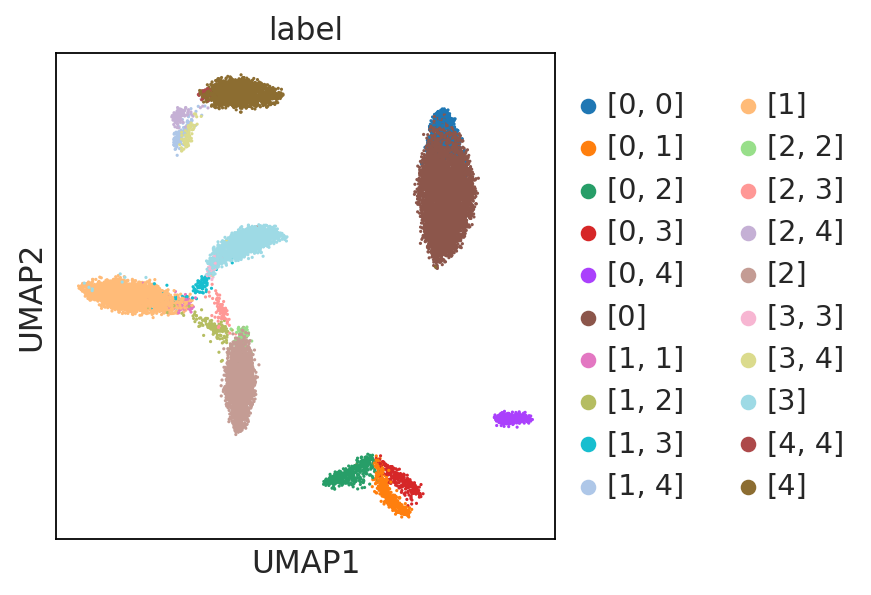

In [37]:
idnew = '2_1'
label = pd.read_csv('../simulator_out/droplets_composition_'+idnew+'.csv')
label.index = label.index.astype(str)
adata_npp.obs['label'] = label['cell_type']
sc.pl.umap(adata_npp,color='label')

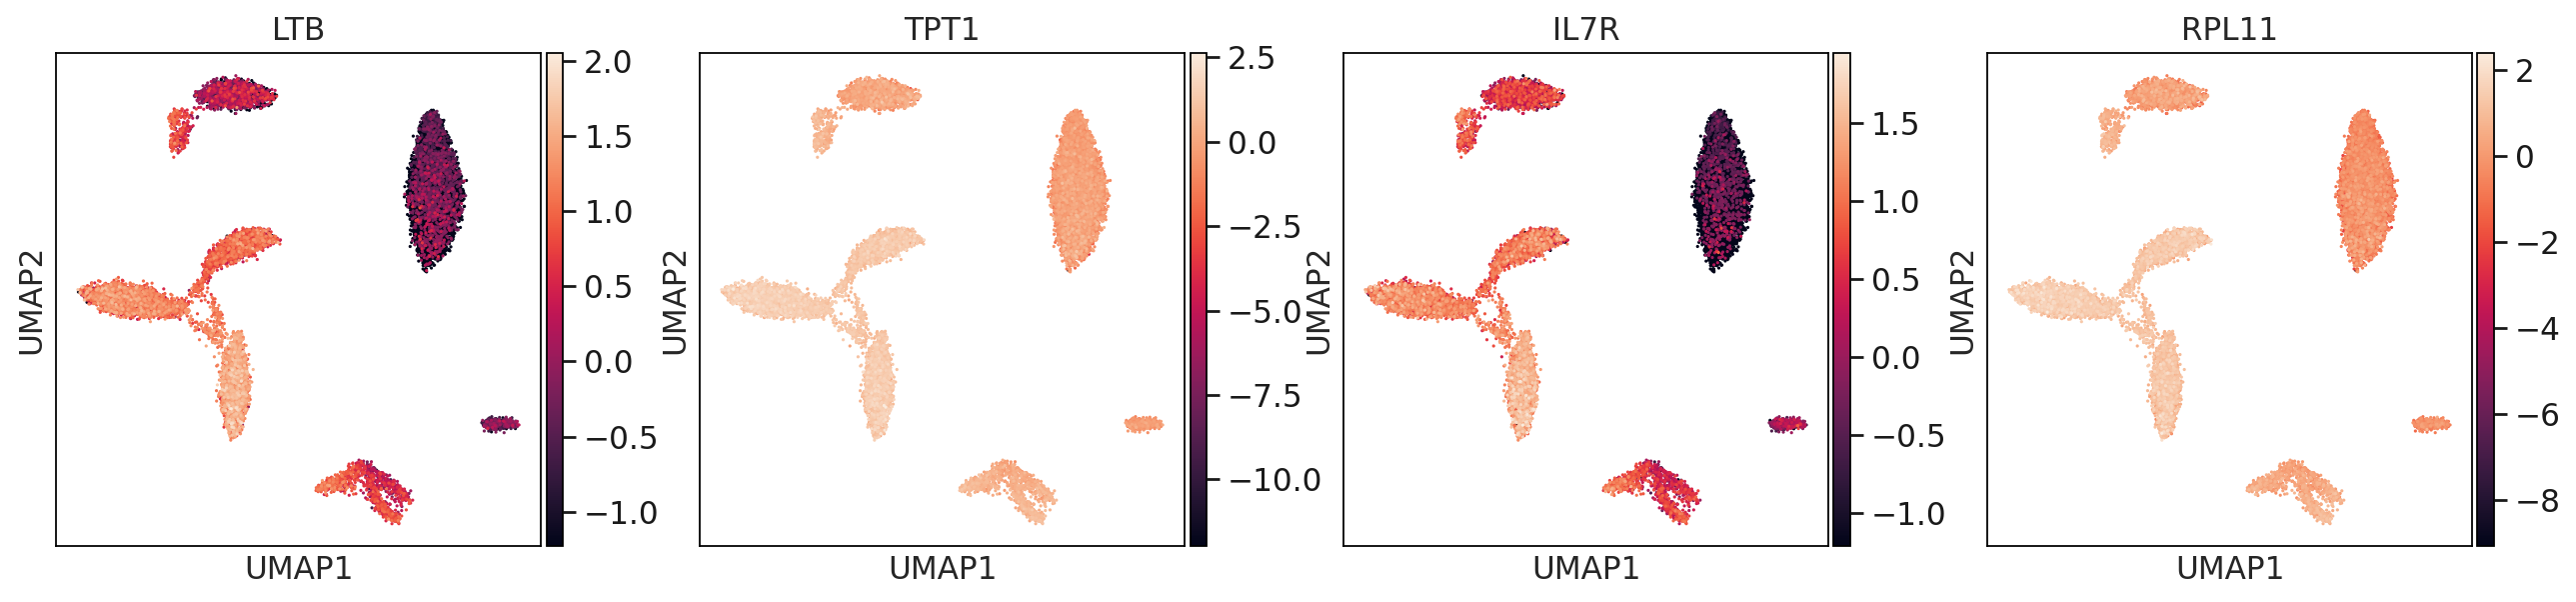

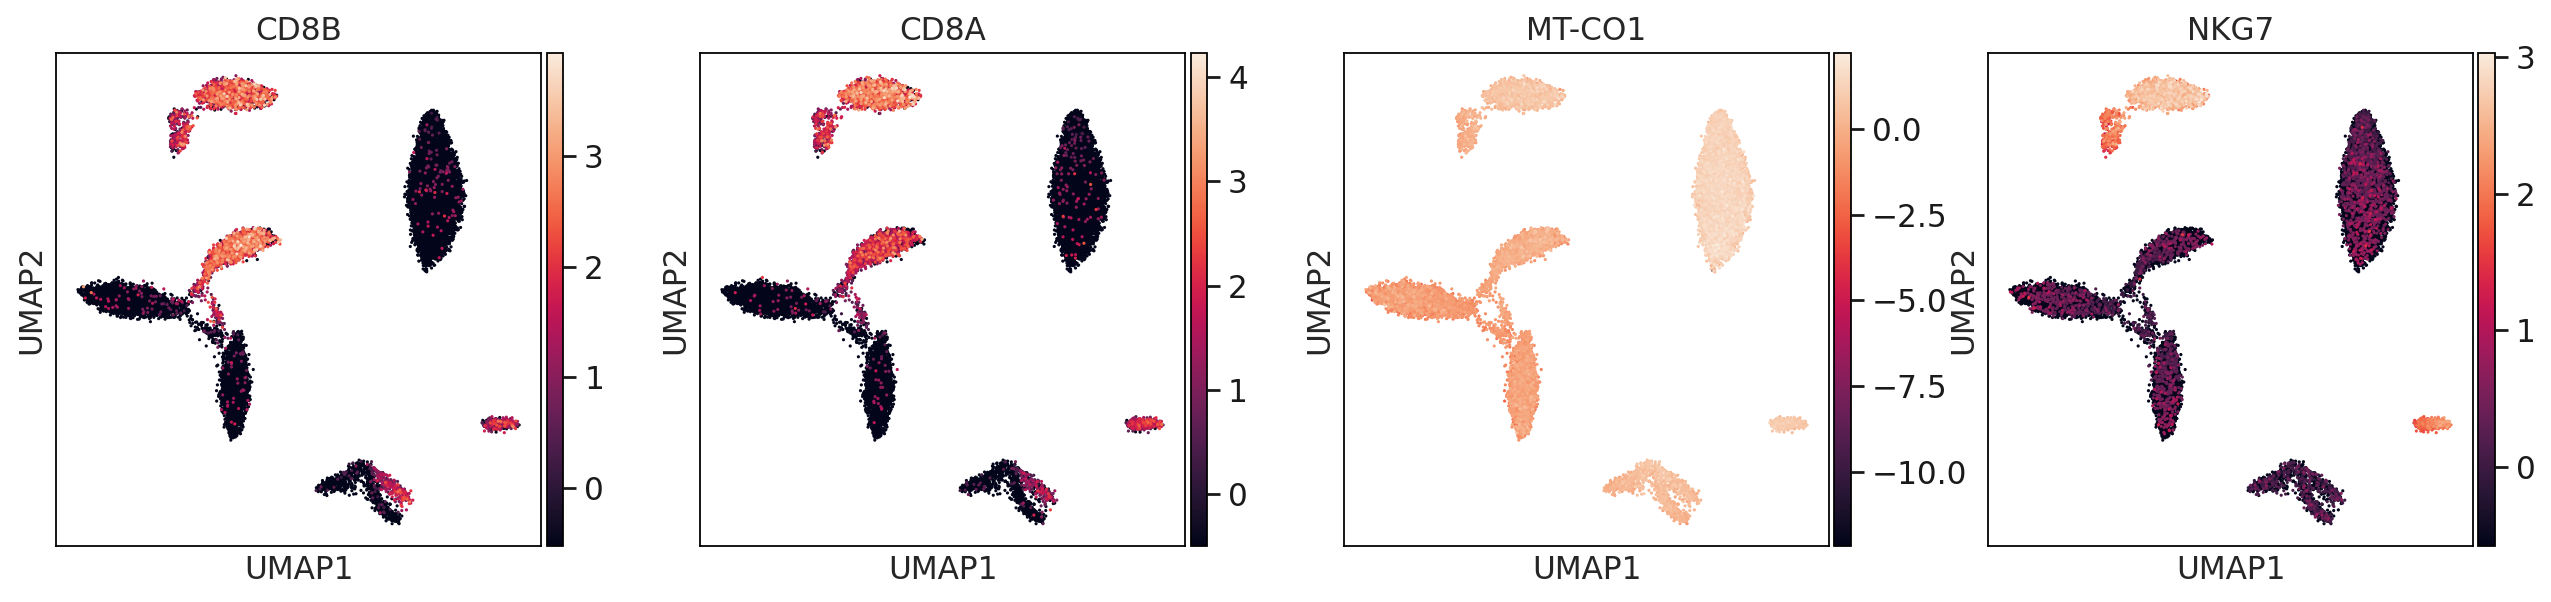

In [41]:
sc.pl.umap(adata_npp,color=dedict[3][:4])
sc.pl.umap(adata_npp,color=dedict[4][:4])

In [17]:
values = adata.obs['pred_rna'].value_counts().keys()
adata.obs['pred_int'] = adata.obs['pred_rna'].replace(values, [int(x.split('_')[0]) for x in values])

In [20]:
adata.obs['pred_int'] = adata.obs['pred_int'].replace({np.NAN: 0})
adata.obs['pred_int']

0         0.0
1        11.0
2         0.0
3        12.0
4        11.0
         ... 
14506    21.0
14507    21.0
14508     0.0
14509     0.0
14510     0.0
Name: pred_int, Length: 14511, dtype: float64

In [35]:
DE_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][:1000])
genes = DE_genes.values.flatten()
genes = list(set(list(genes)))

In [36]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(adata[adata.obs['pred_int']!=0,genes].X, adata[adata.obs['pred_int']!=0,:].obs['pred_int'])
# clf.predict()


LinearDiscriminantAnalysis()

In [38]:
pred_lda_ = clf.predict(adata_npp[:,genes].X)

## Learn alpha

In [278]:
from pyDIMM import DirichletMultinomialMixture

adata_raw = sc.read_h5ad('../simulator_out/RNA_simulator_'+id+'.h5ad')
alpha_ct = pd.DataFrame(index=adata.var_names)
proba_dimm = pd.DataFrame()

for ct in DE_genes.columns:
    inter_genes = list(set(DE_genes[ct].values)&set(adata_new.var_names))
    adata_sub = adata_raw[adata.obs['pred_rna']==ct,inter_genes]
    X = adata_sub.X.toarray()
    dmm = DirichletMultinomialMixture(n_components=1, max_iter=1000, n_init=1, verbose=2, pytorch=1).fit(X)
    alphas = dmm.alphas[0]
    # alpha_ct[ct] = alphas
    adata_sub = adata_new[:,inter_genes]
    proba_dimm[ct] = dmm.predict_proba(adata_sub)
    break


Initialization 0
  Iteration 10	 time lapse 1.59253s	 ll change 7.94094
  Iteration 20	 time lapse 2.52894s	 ll change 3.69255
  Iteration 30	 time lapse 1.76404s	 ll change 1.85136
  Iteration 40	 time lapse 1.78607s	 ll change 1.02599
  Iteration 50	 time lapse 1.74197s	 ll change 0.61872
  Iteration 60	 time lapse 1.26050s	 ll change 0.39895
  Iteration 70	 time lapse 1.73589s	 ll change 0.27115
  Iteration 80	 time lapse 2.09656s	 ll change 0.19217
  Iteration 90	 time lapse 1.47070s	 ll change 0.14088
  Iteration 100	 time lapse 1.60744s	 ll change 0.10617
  Iteration 110	 time lapse 1.80097s	 ll change 0.08188
  Iteration 120	 time lapse 1.36652s	 ll change 0.06438
  Iteration 130	 time lapse 2.53011s	 ll change 0.05146
  Iteration 140	 time lapse 2.05947s	 ll change 0.04172
  Iteration 150	 time lapse 2.11582s	 ll change 0.03424
  Iteration 160	 time lapse 1.11758s	 ll change 0.02841
  Iteration 170	 time lapse 1.95048s	 ll change 0.02379
  Iteration 180	 time lapse 2.04075s	 ll

/home/xinzhu/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: Found array with dim 32. DirichletMultinomialMixture expected <= 2.

In [279]:
dmm.predict_proba()

DirichletMultinomialMixture(max_iter=1000, pytorch=1, verbose=2)

## visualize the key marker in a certain node
#### the node ID is just the number before the node name in tree.pdf

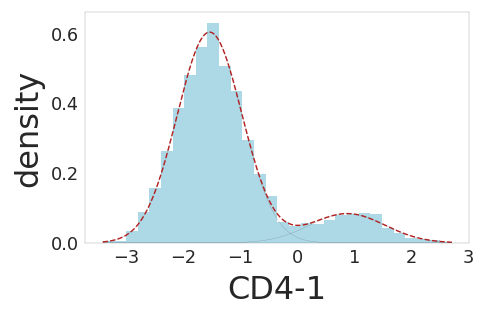

In [ ]:
plot_keymarker(data,traversal,node_ID=2,dpi=128)

In [ ]:
from scipy.stats import multivariate_normal, norm
import numpy as np

def assign_GMM(sample, mean_list, cov_list, weight, if_log=False, marker_list=None):
    # print(cov_list)
    index = sample.index
    # sample = np.array(sample)
    weight = np.array(weight)
    if if_log:
        type_num = np.log(weight/sum(weight))
    else:
        type_num = weight/sum(weight)
    
    p_prior = np.zeros(shape=(len(sample),len(weight)))
    for i in range(len(weight)):
        if if_log:
            # print(i)
            p_prior[:,i] = multivariate_normal.logpdf(np.array(sample.loc[:,marker_list]), mean=np.array(mean_list[i][marker_list]), cov=np.array(cov_list[i].loc[marker_list,marker_list]),allow_singular=True)
            p_prior[:,i] = p_prior[:,i] + type_num[i]
            
        else:
            
            # print([cov_list[i][j,j] for j in range(len(cov_list[i]))])
            # print(sample.loc[:,marker_list[i]])
            # print(mean_list[i])
            # print(cov_list[i])
            p_prior[:,i] = multivariate_normal.pdf(np.array(sample.loc[:,marker_list[i]]), mean=np.array(mean_list[i]), cov=np.array(cov_list[i]))   
            p_prior[:,i] = p_prior[:,i] * type_num[i]
    # p_prior = -p_prior 
    
    p_post = p_prior / (p_prior.sum(axis=1)[:,np.newaxis] )
    pred_label = np.argmin(p_post,axis=1)
    # print(p_prior[:10,:])
    # print(pred_label[:10])
    pred_label = pd.Series(data=pred_label,index=index)
    return pred_label

In [ ]:
leaf_list = traversal.nodelist.copy()
leaf_list.pop(0)
leaf_list.pop(0)
leaf_list.pop(1)

In [ ]:
node = traversal.get_node(3)
mean_list = [node.mean for node in leaf_list] 
cov_list = [node.cov for node in leaf_list]
w_list = [node.weight for node in leaf_list]
simulator = pd.read_csv('../simulator/ADT_simulator_9_10.csv', sep=',', index_col=0, header=0)
raw_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8'])
add_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8','CD3-1'])
#### 尝试用所有cutof<0.5的feature来assign，相当于是一个高维的gate

<AxesSubplot:>

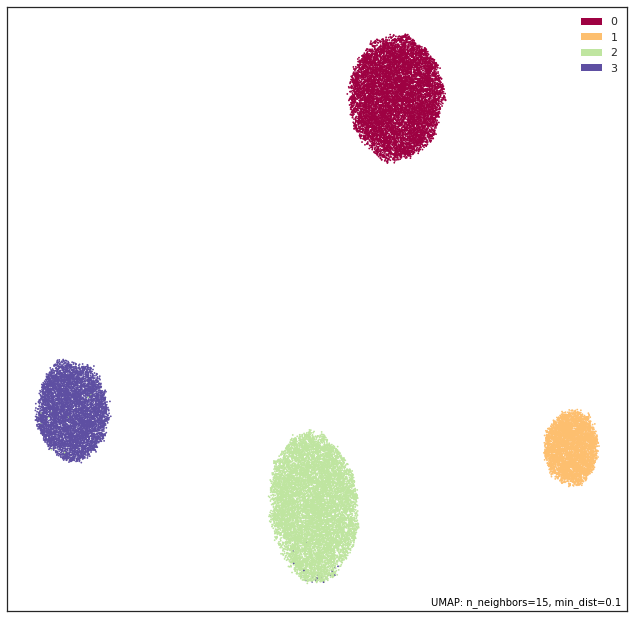

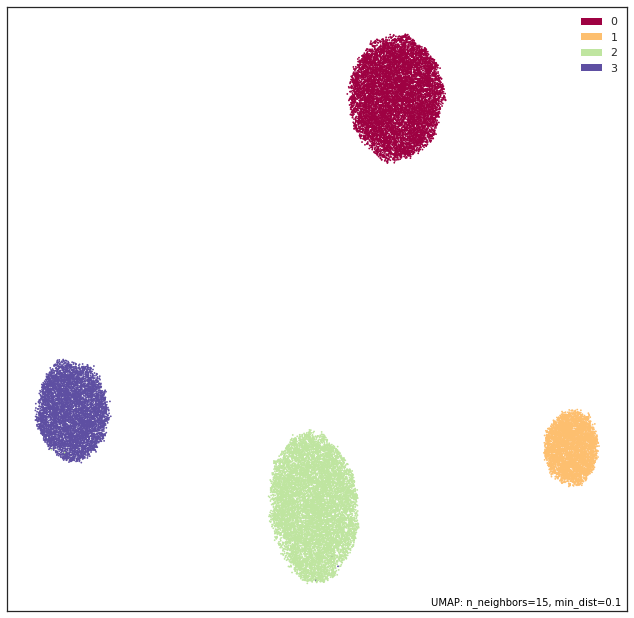

In [ ]:
import umap
import umap.plot
import matplotlib.pyplot as plt

mapper = umap.UMAP().fit(simulator)
umap.plot.points(mapper, labels=raw_label)
umap.plot.points(mapper, labels=add_label)

In [ ]:
raw_label.iloc[20675:].value_counts()
# add_label.iloc[20675:].value_counts()

2    9851
3      21
dtype: int64

In [ ]:
# add_label.index = simulator.index
simulator[raw_label==3].to_csv('../simulator/ADT_simulator_9_11.csv')

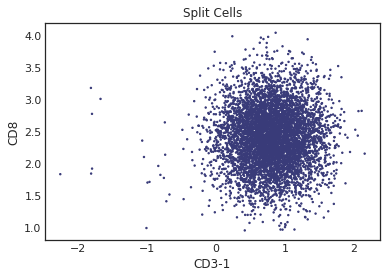

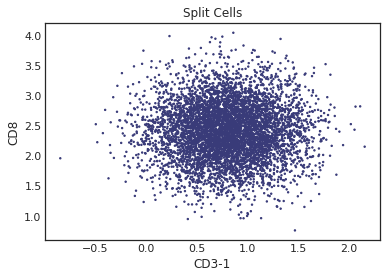

In [ ]:
from CITEsort.Visualize import visualize_2dim

visualize_2dim(simulator[raw_label==3]['CD3-1'],simulator[raw_label==3]['CD8'],raw_label[raw_label==3])
visualize_2dim(simulator[add_label==3]['CD3-1'],simulator[add_label==3]['CD8'],add_label[add_label==3])

In [ ]:
keys = []
for i in range(28):
    node = traversal.get_node(i)
    if list(node.key) != 'leaf':
        print(node.key)

('CD26-1',)
('IgD',)
('CD26-1',)
('leaf',)
('CD72',)
('CD4-1',)
('CD4-1',)
('CD27', 'CD8a')
('CD8a',)
('leaf',)
('CD244',)
('CD4-1',)
('leaf',)
('CD27',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)
('CD244',)
('leaf',)
('leaf',)
('CD158', 'CD21')
('CD3-1',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)


In [ ]:
'IgD',
'CD26-1',
'CD72',
'CD4-1',
'CD27', 'CD8a
'CD8a',
'CD244',
'CD4-1',
'CD27',
'CD244',
'CD158', 'CD21',
'CD3-1'

TypeError: unhashable type: 'list'